### Startup imports

In [3]:
import sys
import pandas as pd
sys.path.append('../')

from autoqchem.molecule import molecule
from autoqchem.slurm_manager import slurm_manager
from autoqchem.helper_classes import slurm_status
from autoqchem.helper_classes import slurm_job

from autoqchem.draw_utils import draw

from scripts.generate_smiles import *

import os
import re

import logging
logging.basicConfig(level=logging.INFO)

### Connect to the cluster

In [ ]:
#Enter your username
from autoqchem.slurm_manager import slurm_manager
import logging
logging.basicConfig(level=logging.INFO)

sm=slurm_manager(user='jfenogli', host='129.199.34.42', file_name='test', port = 22)

sm.connect()


INFO:autoqchem.slurm_manager:Creating connection to 129.199.34.42 as jfenogli


In [4]:
sm.get_job_stats()

status,failed,incomplete
jobs,2,2


### Provide some smiles string(s)

In [3]:
smi_already_run=[]

jobs_dict = sm.get_jobs()
for key in jobs_dict.keys():    
    can = jobs_dict[key].can
    smi_already_run.append(can)

In [4]:
smi_already_run

['COc1ccc2c(c1OC)OB1Oc3c(ccc(OC)c3OC)N12',
 'COc1ccc2c(c1OC)O[B-]1(F)Oc3c(ccc(OC)c3OC)N21']

In [5]:
smi_to_run = generate_boronics(1, smi_already_run, 'ONO')

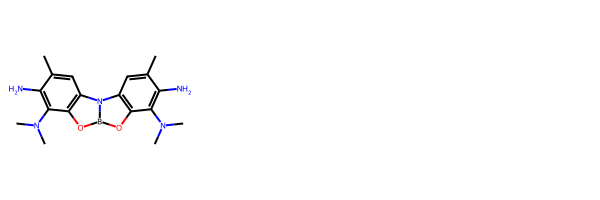

In [6]:
smi_not_F = smi_to_run

mols = [Chem.MolFromSmiles(smi) for smi in smi_not_F]
mols_F = get_fluoride_adduct(mols)
smi_F = [Chem.MolToSmiles(mol) for mol in mols_F]
Chem.Draw.MolsToGridImage(mols)

### Initialize the molecules and generate conformations

We will use some ```for``` loops to loop over the smiles

In [7]:
mols_to_run = []

for i in range(len(smi_not_F)):
    mol = molecule(smi_not_F[i], num_conf=1)
    mol_F = molecule(smi_F[i], num_conf=1)
    mols_to_run.append(mol)
    mols_to_run.append(mol_F)    

Draw some molecules

Here you can see that the starting conformers are not optimized, which may cause some Gaussian geometry optimizations to crash

In [11]:
draw(mols_to_run[0].mol)

interactive(children=(Dropdown(description='confId', options=(0,), value=0), Output()), _dom_classes=('widget-…

<function autoqchem.draw_utils._graph_conf(m, confId=0, energies=[])>

### Create gaussian jobs for each conformation

In [8]:
for mol in mols_to_run:
    sm.create_jobs_for_molecule(mol, workflow_type="equilibrium", theory = "b3lyp", light_basis_set="6-31G(d)", partition = 'qAVX2', n_processors = 20)

INFO:autoqchem.gaussian_input_generator:Generating Gaussian input files for 1 conformations.
INFO:autoqchem.gaussian_input_generator:Generating Gaussian input files for 1 conformations.


In [9]:
sm.get_job_stats(split_by_can=False)

status,created
jobs,2


### Remove Jobs

In case you want want to remove some jobs

In [17]:
jobs_failed = sm.get_jobs(slurm_status.failed)

In [18]:
smi_to_rm = [job.can for job in jobs_failed.values()]

In [16]:
smi_to_rm = smi_already_run

In [17]:
for smi in smi_to_rm :
    sm.remove_jobs(sm.get_jobs(can=smi))

### Submit the jobs to the server 


Then, check the status of the jobs on the server

In [9]:
sm.submit_jobs()

INFO:autoqchem.slurm_manager:Submitting 2 jobs.
INFO:paramiko.transport.sftp:[chan 2] Opened sftp connection (server version 3)


Submitted batch job 37932


INFO:autoqchem.slurm_manager:Submitted job bbe8a674a7ae3172e4c81fc4e4984fdc, job_id: 37932.


Submitted batch job 37933


INFO:autoqchem.slurm_manager:Submitted job e158b3cd77b66901e403f45a836ec901, job_id: 37933.


In [20]:
sm.squeue(summary=False)

,JOBID,PARTITION,NAME,USER,ST,TIME,NODES,NODELIST(REASON)


In [15]:
sm._scancel

<bound method slurm_manager._scancel of <autoqchem.slurm_manager.slurm_manager object at 0x000001D392062A70>>

### Retrieve jobs

If there are some finished jobs the log files will be checked for completion and downloaded locally.

In [5]:
sm.retrieve_jobs()

INFO:autoqchem.slurm_manager:There are no jobs submitted to cluster. Nothing to retrieve.


In [6]:
sm.get_job_stats(split_by_can=False)

status,failed,incomplete
jobs,2,2


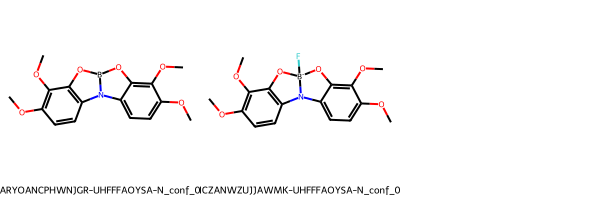

In [7]:
jobs_failed = sm.get_jobs(slurm_status.failed)
smiles_failed = [ job.can for job in jobs_failed.values()]
names = [job.base_name for job in jobs_failed.values()]
mols_failed = [Chem.MolFromSmiles(smi) for smi in smiles_failed]
Chem.Draw.MolsToGridImage(mols_failed, legends = names)

### Resubmit incomplete jobs

In [8]:
sm.resubmit_incomplete_jobs()

INFO:autoqchem.slurm_manager:Substituting last checked geometry in the new input file.
INFO:autoqchem.slurm_manager:Substituting last checked geometry in the new input file.
INFO:paramiko.transport.sftp:[chan 2] Opened sftp connection (server version 3)
sbatch: error: invalid partition specified: qAVX2
sbatch: error: Batch job submission failed: Invalid partition name specified


UnexpectedExit: Encountered a bad command exit code!

Command: 'cd /data/jfenogli/test/WJQWYQHIAKQLPI-UHFFFAOYSA-N && \n sbatch WJQWYQHIAKQLPI-UHFFFAOYSA-N_conf_0.sh'

Exit code: 1

Stdout: already printed

Stderr: already printed



In [14]:
sm.get_job_stats()

status
jobs


### Upload molecules to the database

In [7]:
sm.upload_done_molecules_to_db(tags=['boron_LA_ONO_ar_2'])

INFO:autoqchem.slurm_manager:There are 1 finished molecules ['N#Cc1c([N+](=O)[O-])cc2c(c1C#N)OB1Oc3c(cc([N+](=O)[O-])c(C#N)c3C#N)N12'].
INFO:autoqchem.slurm_manager:Molecule N#Cc1c([N+](=O)[O-])cc2c(c1C#N)OB1Oc3c(cc([N+](=O)[O-])c(C#N)c3C#N)N12 has 0 / 1 duplicate conformers.
INFO:autoqchem.slurm_manager:Removing 0 / 1 jobs and log files that contain duplicate conformers.
INFO:autoqchem.slurm_manager:Uploaded descriptors to DB for smiles: N#Cc1c([N+](=O)[O-])cc2c(c1C#N)OB1Oc3c(cc([N+](=O)[O-])c(C#N)c3C#N)N12, number of conformers: 1, DB molecule id 6530e23736dc4c9c0270f942.


### Reorganization energy jobs

In [14]:
from scripts.reorganization_energy_utils import *

folder name of remote directory: test
user: jfenogli
host: hermite.chimie.ens.fr
port: 8000


In [19]:
smiles_LA = smi_already_run

In [20]:
smiles_LA

['O=[N+]([O-])c1cccc2c1OB1Oc3c(cccc3[N+](=O)[O-])N12',
 'O=[N+]([O-])c1cccc2c1O[B-]1(F)Oc3c(cccc3[N+](=O)[O-])N21',
 'O=[N+]([O-])c1ccc2c(c1)OB1Oc3cc([N+](=O)[O-])ccc3N12',
 'O=[N+]([O-])c1ccc2c(c1)O[B-]1(F)Oc3cc([N+](=O)[O-])ccc3N21']

In [21]:
smi_to_rm = []
for smi in smiles_LA : 
    if '[B-]' in smi :
        smi_to_rm.append(smi)
    if '[BH-]' in smi :
        smi_to_rm.append(smi)
for smi in smi_to_rm :
    smiles_LA.remove(smi)

In [22]:
for smi in smiles_LA[:]:
    create_reorg_geom_input_files(smi)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Juliette\\AppData\\Local\\autoqchem\\hermite/test/ADNQGMVGVZYYEA-UHFFFAOYSA-N/ADNQGMVGVZYYEA-UHFFFAOYSA-N_conf_0.log'

In [18]:
for smi in smiles_LA[:]:
    submit_pyramid_spe_calc(smi)

In [19]:
for smi in smiles_LA[:]:
    retrieve_pyramid_log_file(smi)

### Compute FIA

In [25]:
from scripts.compute_FIA_HIA_utils import *
from autoqchem.db_functions import *
from scripts.machine_learning_utils import *

folder name of remote directory: test
user: jfenogli
host: hermite.chimie.ens.fr
port: 8000


In [27]:
from scripts.manage_data import *

In [28]:
mol_df_ONO = db_select_molecules(tags=["boron_LA_ONO_ar_2"])

data_ONO = descriptors(["boron_LA_ONO_ar_2"], presets=['global', 'substructure'], 
            conf_option='mean', 
            solvent='None', 
            functional='M062X', 
            basis_set="6-31G(d)",
            substructure='B')
data_ONO = LA_only(data_ONO)

smiles_ONO = []
for i in mol_df_ONO.axes[0]:
    smiles_ONO.append(mol_df_ONO.at[i,'can'])

smi_to_rm = []
for smi in smiles_ONO : 
    if '[B-]' in smi :
        smi_to_rm.append(smi)
    if '[BH-]' in smi :
        smi_to_rm.append(smi)
for smi in smi_to_rm :
    smiles_ONO.remove(smi)
    
smiles = smiles_ONO

C:\Users\Juliette\Desktop\FIA-publi\notebooks\..\autoqchem\db_functions.py:216: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = pd.concat([grouped['metadata', 'molecule_id', 'name'].first(),
C:\Users\Juliette\Desktop\FIA-publi\notebooks\..\autoqchem\db_functions.py:216: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = pd.concat([grouped['metadata', 'molecule_id', 'name'].first(),
C:\Users\Juliette\Desktop\FIA-publi\notebooks\..\autoqchem\db_functions.py:368: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  dg = pd.concat([d['descriptors'] for can, d in descs_df.iteritems()], axis=1, sort=True)


In [11]:
FIA = list_FIA(smiles)

[12:39:21] WARNING: not removing hydrogen atom without neighbors


In [ ]:
FIA_str = []
for fia in FIA : 
    if type(fia) != str :
        fia = round(fia,3)
    FIA_str.append(str(fia))
mols = []
for i in range(len(smiles_ONO)):
    mols.append(Chem.MolFromSmiles(smiles_ONO[i]))
    #mols.append(Chem.MolFromSmiles(smiles_F[i]))            
Chem.Draw.MolsToGridImage(mols, molsPerRow=10, subImgSize=(400,500), legends = FIA_str, maxMols=200)

In [31]:
reorg_nrjs = reorganization_nrj(smiles)

In [19]:
def replace(value):
    if type(value)==str :
        return(None)
    elif value == None : 
        return(None)
    elif value <=0 :
        return(None)
    elif value >=2000 :
        return(None)
    else :
        return(value)

In [20]:
FIA = [replace(fia) for fia in FIA]
#HIA = [replace(hia) for hia in FIA]
#reorg_nrjs = [replace(nrj) for nrj in reorg_nrjs]

In [23]:
len(FIA)

179

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame()

In [32]:
df['SMILES']=smiles
df['FIA']=FIA

,SMILES,FIA


In [40]:
df = df.set_index('SMILES')
df.to_csv("tables/data/table_smiles_FIA_ONO.csv")